<a href="https://colab.research.google.com/github/KirkDCO/HandsOnML_Exercises/blob/main/Ch17_Q10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 17 Question 10

Train a variational autoencoder on the image dataset of your choice, and use it to generate images. Alternatively, you can try to find an unlabeled dataset that you are interested in and see if you can generate new samples.

## Finding an image dataset
For this exercise, I wanted to find an interesting image dataset that was not too complex but also not too simple.  A dataset with RGB images would also be nice.  After much searching through the [TensorFlow Datasets Catalog](https://www.tensorflow.org/datasets/catalog/overview) and then [Kaggle Datasets](https://www.kaggle.com/datasets), I found the Kaggle [Flowers Dataset](https://www.kaggle.com/datasets/l3llff/flowers) consisting of 13,838 JPEG 96 x 96 images of 14 different flowers.

I stored the images on my Google Drive in a folder called _flowers_ which I could then access from Google Colaboratory.  Accessing image files from Google Drive can be slow, so I copied the _folder_ directory from my Google Drive location to the _sample_data_ directory in Colab.  The folder is only about 230 MB, so it doesn't take much time to copy and doesn't occupy a huge amount of space within my Colab instance.

In [1]:
!cp -r drive/MyDrive/Colab\ Notebooks/HandsOnML/Ch17_Q10/flowers sample_data/.

First step is to import needed packages and set up global variables, and create generators for the flower images.

In [2]:
# imports and globals

import tensorflow as tf
from tensorflow import keras
K = keras.backend

import numpy as np
import matplotlib.pyplot as plt
import random

BATCH_SIZE = 32 

IMG_WIDTH  = 96 
IMG_HEIGHT = 96 

ENCODING_SIZE = 8 

In [3]:
# create a flower with labels generator
flower_generator = tf.keras.preprocessing.image_dataset_from_directory(
  "sample_data/flowers",
  seed = 84,
  image_size = (IMG_HEIGHT, IMG_WIDTH),
  batch_size = BATCH_SIZE, 
  labels = 'inferred'
)

# keep the flower names for future reference
flower_names = flower_generator.class_names

# create a training data generator 
training_generator = tf.keras.preprocessing.image_dataset_from_directory(
  "sample_data/flowers",
  seed = 42,
  image_size = (IMG_HEIGHT, IMG_WIDTH),
  batch_size = BATCH_SIZE, 
  labels = None, 
  validation_split = 0.2,
  subset = 'training'
)

# and a validation set generator
validation_generator = tf.keras.preprocessing.image_dataset_from_directory(
  "sample_data/flowers",
  seed = 42,
  image_size = (IMG_HEIGHT, IMG_WIDTH),
  batch_size = BATCH_SIZE, 
  labels = None, 
  validation_split = 0.2,
  subset = 'validation'
)

# autoencoders require the input matrix as both the input
# and the output
# provide input -> input for the autoencoder
# and, do scaling
def replicate_inputs_to_outputs(images):
  return images/255, images/255

# create prefetch generators to speed things up a bit
training_generator = training_generator.prefetch(128)
validation_generator = validation_generator.prefetch(128)

# create the final generators to be used in training the autoencoders
X_train = training_generator.map(replicate_inputs_to_outputs)
X_valid = validation_generator.map(replicate_inputs_to_outputs)


Found 13838 files belonging to 14 classes.
Found 13838 files belonging to 1 classes.
Using 11071 files for training.
Found 13838 files belonging to 1 classes.
Using 2767 files for validation.


Taking a look at a few random images from the dataset we see that most of the images are nicely centered and often there is just one flower per image.  In some cases there are many flower or there are other background elements in image.  Dandelions are interesting as they may have the yellow flower or the white puffball seed stage.

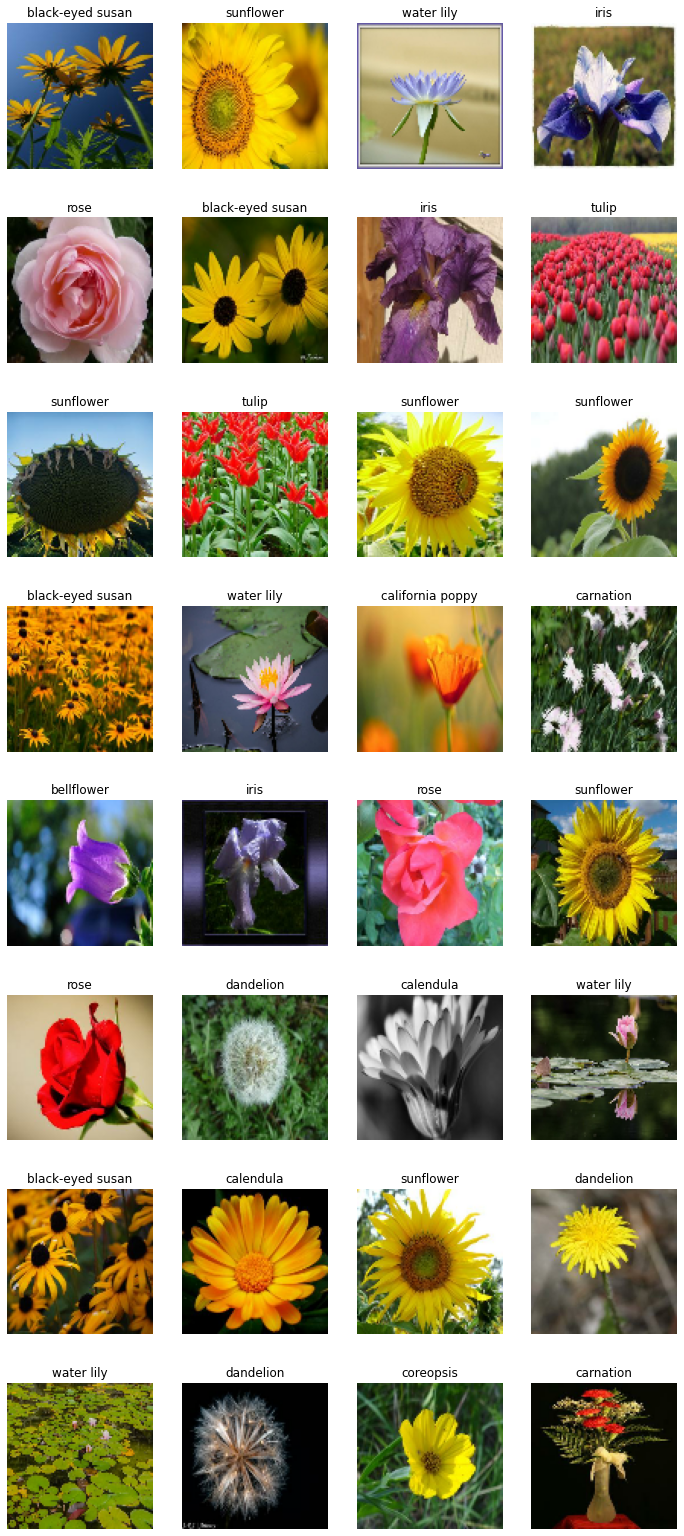

In [ ]:
# visualize a few random flowers
plt.figure(figsize=(12, 28))

for images, labels in flower_generator.take(1):
  for i in range(len(images)):
      ax = plt.subplot(8, 4, i + 1)
      plt.imshow(images[i].numpy().astype("uint8"))
      plt.title(flower_names[labels[i]])
      plt.axis("off")

## Convolutional Autoencoder

I wanted to see how a convolutional autoencoder would perform with respect to image reconstruction.  I created a very simple 3 stage convolutional autoencoder consiting of 32 features for the original  96 x 96 RGB imgaes, followed by Max Pooling and 64 features for the 48 x 48 x 32 feature map, another Max Pooling step and finally 128 features for the 24 x 24 x 32 feature map.  I tried a number of different encoding layer sizes and found 1024 to produce better results that 512, and nearly as good as 2048.  For the autoencoder, the encoding layer needed to be substantially larger than the variational autoencoder.  (See the VAE section for more about encodings there.)

In [16]:
ENCODING_SIZE = 1024

# build a convolutional auto-encoder 
encoder = keras.models.Sequential([
            keras.layers.Conv2D(32, input_shape = [IMG_WIDTH, IMG_HEIGHT, 3], kernel_size = 3, 
                                padding = 'same', activation = 'relu'),
            keras.layers.MaxPool2D(),
            keras.layers.Conv2D(64, kernel_size = 3,
                                padding = 'same', activation = 'relu'),
            keras.layers.MaxPool2D(),
            keras.layers.Conv2D(128, kernel_size = 3,
                                padding = 'same', activation = 'relu'),
            keras.layers.Flatten(),
            keras.layers.Dense(ENCODING_SIZE)
])

encoder.summary()

decoder = keras.models.Sequential([
            keras.layers.Dense(128 * 24 * 24 , activation = "relu", input_shape = [ENCODING_SIZE]),
            keras.layers.Reshape([24, 24, 128]),
            keras.layers.Conv2DTranspose(filters = 64, kernel_size = 3, strides = 2,
                                         padding = "same", activation = "relu"),
            keras.layers.Conv2DTranspose(filters = 32, kernel_size = 3, strides = 2,
                                         padding = "same", activation = "relu"),
            keras.layers.Conv2DTranspose(filters = 3, kernel_size = 3, 
                                         padding = 'same', activation = 'sigmoid')
])

decoder.summary()

ae = keras.models.Sequential([encoder, decoder])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 96, 96, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 48, 48, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 24, 24, 128)       73856     
                                                                 
 flatten_1 (Flatten)         (None, 73728)            

In [17]:
# add learning rate scheduling 
def exponential_decay_fn(epoch):
  return 0.001 * 0.1 ** (epoch / 10)

lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)

# add early stopping
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 5, restore_best_weights = True)

# clear the session for a clean run
keras.backend.clear_session()
tf.random.set_seed(42)

# compile and run
ae.compile(loss = "mean_squared_error", optimizer = keras.optimizers.Nadam())
history = ae.fit(X_train, validation_data = X_valid,  epochs = 25, \
                 callbacks = [lr_scheduler, early_stopping_cb])

Epoch 1/25
346/346 [==============================] - 31s 85ms/step - loss: 0.0452 - val_loss: 0.0368 - lr: 0.0010
Epoch 2/25
346/346 [==============================] - 29s 83ms/step - loss: 0.0274 - val_loss: 0.0237 - lr: 7.9433e-04
Epoch 3/25
346/346 [==============================] - 29s 83ms/step - loss: 0.0216 - val_loss: 0.0197 - lr: 6.3096e-04
Epoch 4/25
346/346 [==============================] - 29s 83ms/step - loss: 0.0183 - val_loss: 0.0176 - lr: 5.0119e-04
Epoch 5/25
346/346 [==============================] - 29s 85ms/step - loss: 0.0160 - val_loss: 0.0158 - lr: 3.9811e-04
Epoch 6/25
346/346 [==============================] - 29s 83ms/step - loss: 0.0144 - val_loss: 0.0153 - lr: 3.1623e-04
Epoch 7/25
346/346 [==============================] - 29s 83ms/step - loss: 0.0132 - val_loss: 0.0143 - lr: 2.5119e-04
Epoch 8/25
346/346 [==============================] - 29s 83ms/step - loss: 0.0122 - val_loss: 0.0137 - lr: 1.9953e-04
Epoch 9/25
346/346 [==============================] 

In [19]:
# save the trained ae
ae.save('drive/MyDrive/Colab Notebooks/HandsOnML/Ch17_Q10/AE_1024enc')

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/HandsOnML/Ch17_Q10/AE_1024enc/assets


In [ ]:
# load the saved ae
ae = keras.models.load_model('drive/MyDrive/Colab Notebooks/HandsOnML/Ch17_Q10/AE_1024enc')

Looking at the reconstructions for a few random flowers, they look quite good. Trying larger encoding (2048) didn't produce substantially better results.

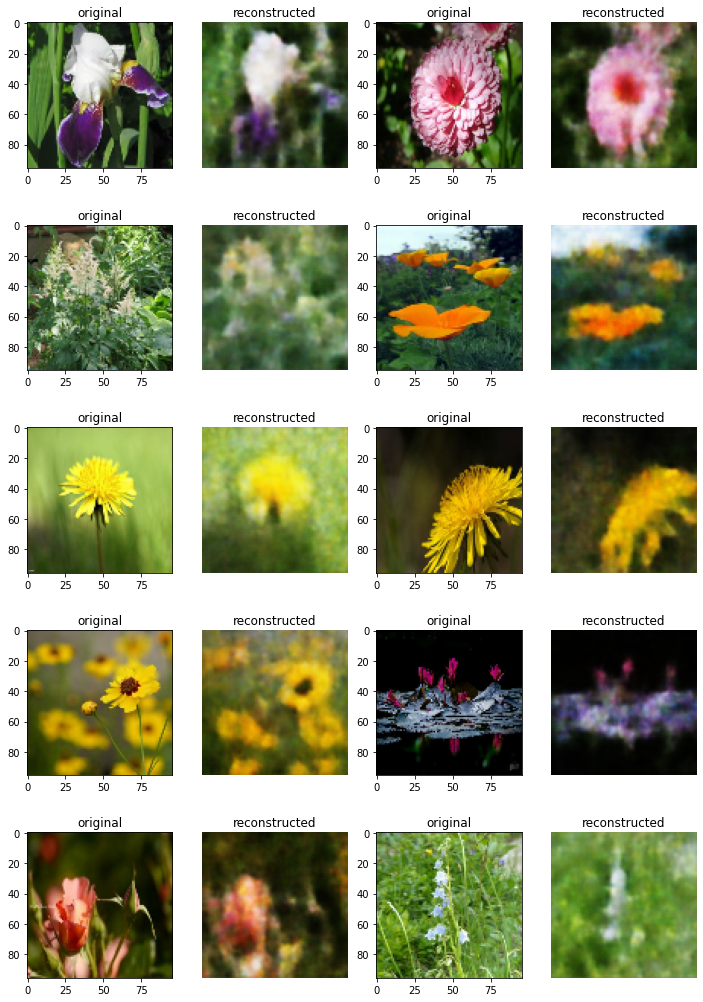

In [20]:
# visualize a few random flowers
# and their reconstructions
plt.figure(figsize=(12, 18))

for images, _ in X_valid.take(1):
  ae_images = ae.predict(images)
  for i in range(10):
    ax = plt.subplot(5, 4, (i * 2) + 1)
    plt.imshow(images[i])
    plt.title('original')

    ax = plt.subplot(5, 4, (i * 2) + 2)
    plt.imshow(ae_images[i])
    plt.title('reconstructed')
    plt.axis("off")

## Variational Autoencoder 

Next, I built a convolutional variational autoencoder with the a structure similar to the convolutional autoencoder above, but with a parametric encoding layer.  I dropped the Max Pooling layers in favor of using strides of 2.  Also, I found that while relu activations worked well, the colors tended to get washed out compared to using selu activations.  

I experimented with lots of different options - larger/smaller enocoding layers, more/less convolutional layers, more/less features in each convolutional layer, additional dense layers, etc.  

Initially, I used a very large encoding layer - 1024 components - however this lead to generated images that looked nothing like flowers despite having flower-like qualities and colors.  Through some experimentation, I found that dropping this to a much smaller value between 8 and 16 led to much more flower-like images.

The images produced with this method resembled the average flower type images produced further below - the major characteristics of the flower are recognizable, but they are very blurry and lack significant detail.

In [8]:
ENCODING_SIZE = 8 

# build a VAE based on AE structure above
class Sampling(keras.layers.Layer):
  def call(self, inputs):
    mean, log_var = inputs
    return K.random_normal(tf.shape(log_var)) * K.exp(log_var /2) + mean

inputs = keras.layers.Input(shape = [IMG_WIDTH, IMG_HEIGHT, 3])
z = keras.layers.Conv2D(64, input_shape = [IMG_WIDTH, IMG_HEIGHT, 3], kernel_size = 3, 
                        strides = 1, padding = 'same', activation = 'selu',
                        kernel_initializer='lecun_normal')(inputs)
z = keras.layers.Conv2D(128, kernel_size = 3, strides = 2,
                        padding = 'same', activation = 'selu',
                        kernel_initializer='lecun_normal')(z)
z = keras.layers.Conv2D(256, kernel_size = 3, strides = 2,
                        padding = 'same', activation = 'selu',
                        kernel_initializer='lecun_normal')(z)
z = keras.layers.Conv2D(512, kernel_size = 3, strides = 2,
                        padding = 'same', activation = 'selu',
                        kernel_initializer='lecun_normal')(z)
z = keras.layers.Flatten()(z)
codings_mean = keras.layers.Dense(ENCODING_SIZE)(z)
codings_log_var = keras.layers.Dense(ENCODING_SIZE)(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.Model(inputs = [inputs], outputs = [codings_mean, codings_log_var, codings])

variational_encoder.summary()

decoder_inputs = keras.layers.Input(shape = [ENCODING_SIZE])
x = keras.layers.Dense(512 * 12 * 12, activation = "selu", input_shape = [ENCODING_SIZE])(decoder_inputs)
x = keras.layers.Reshape([12, 12, 512])(x)
x = keras.layers.Conv2DTranspose(filters = 512, kernel_size = 3, strides = 1,
                                 padding = "same", activation = "selu")(x)
x = keras.layers.Conv2DTranspose(filters = 256, kernel_size = 3, strides = 2,
                                 padding = "same", activation = "selu")(x)
x = keras.layers.Conv2DTranspose(filters = 128, kernel_size = 3, strides = 2,
                                 padding = "same", activation = "selu")(x)
x = keras.layers.Conv2DTranspose(filters = 64, kernel_size = 3, strides = 2,
                                 padding = "same", activation = "selu")(x)
outputs = keras.layers.Conv2DTranspose(filters = 3, kernel_size = 3, strides = 1,
                                       padding = 'same', activation = 'sigmoid')(x)
variational_decoder = keras.Model(inputs = [decoder_inputs], outputs = [outputs])

variational_decoder.summary()

_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
vae = keras.Model(inputs = [inputs], outputs = [reconstructions])

vae.summary()

# add a loss function
latent_loss = -0.5 * K.sum(1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
                           axis = -1)
vae.add_loss(K.mean(latent_loss) / 27648.)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 96, 96, 64)   1792        ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 48, 48, 128)  73856       ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 24, 24, 256)  295168      ['conv2d_1[0][0]']               
                                                                                              

In [9]:
# add learning rate scheduling 
def exponential_decay_fn(epoch):
  return 0.0001 * 0.1 ** (epoch / 10)

lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)

# add early stopping
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 5, restore_best_weights = True)

# clear the session for a clean run
keras.backend.clear_session()
tf.random.set_seed(42)

vae.compile(loss = 'mean_squared_error', optimizer = keras.optimizers.Nadam())
history = vae.fit(X_train, validation_data = X_valid,  epochs = 50, \
                  callbacks = [lr_scheduler, early_stopping_cb])

Epoch 1/50
346/346 [==============================] - 38s 103ms/step - loss: 0.0468 - val_loss: 0.0394 - lr: 1.0000e-04
Epoch 2/50
346/346 [==============================] - 35s 101ms/step - loss: 0.0373 - val_loss: 0.0367 - lr: 7.9433e-05
Epoch 3/50
346/346 [==============================] - 35s 101ms/step - loss: 0.0356 - val_loss: 0.0353 - lr: 6.3096e-05
Epoch 4/50
346/346 [==============================] - 35s 101ms/step - loss: 0.0348 - val_loss: 0.0348 - lr: 5.0119e-05
Epoch 5/50
346/346 [==============================] - 35s 101ms/step - loss: 0.0343 - val_loss: 0.0349 - lr: 3.9811e-05
Epoch 6/50
346/346 [==============================] - 35s 101ms/step - loss: 0.0341 - val_loss: 0.0344 - lr: 3.1623e-05
Epoch 7/50
346/346 [==============================] - 35s 101ms/step - loss: 0.0338 - val_loss: 0.0344 - lr: 2.5119e-05
Epoch 8/50
346/346 [==============================] - 35s 101ms/step - loss: 0.0337 - val_loss: 0.0343 - lr: 1.9953e-05
Epoch 9/50
346/346 [====================

In [21]:
# save the trained vae components
vae.save('drive/MyDrive/Colab Notebooks/HandsOnML/Ch17_Q10/VAEwts_8enc')
variational_encoder.save('drive/MyDrive/Colab Notebooks/HandsOnML/Ch17_Q10/VAE_encoder_wts_8enc')
variational_decoder.save('drive/MyDrive/Colab Notebooks/HandsOnML/Ch17_Q10/VAE_decoder_wts_8enc')

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/HandsOnML/Ch17_Q10/VAEwts_8enc/assets
INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/HandsOnML/Ch17_Q10/VAE_encoder_wts_8enc/assets
INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/HandsOnML/Ch17_Q10/VAE_decoder_wts_8enc/assets


In [ ]:
# load the saved vae components
vae = keras.models.load_model('drive/MyDrive/Colab Notebooks/HandsOnML/Ch17_Q10/VAEwts')
variational_encoder.load_model('drive/MyDrive/Colab Notebooks/HandsOnML/Ch17_Q10/VAE_encoder_wts_1024')
variational_decoder.load_model('drive/MyDrive/Colab Notebooks/HandsOnML/Ch17_Q10/VAE_decoder_wts_1024')

## Random Flower Generation 

Using the trained VAE, images were generated by decoding a set of random encoding values.  Looking at the results, they could be considered "flower-like" with some much more like flowers than others, but generally the aren't convincing.  

Each image has a centralized, colored shape that is typically surrounded by a green background.  This is likely reflective of the typical image having a single central flower with a dark or leafy/grassy background. Attempting an encoding layer with 2048 components led to slighlty sharper images, but essentially the same results shown here with 1024 components in the encoding layer.  Increasing or decreasing the number of convolutional layers or the number of features in each convolutional layer lead to images with less detail and less sharp colors.

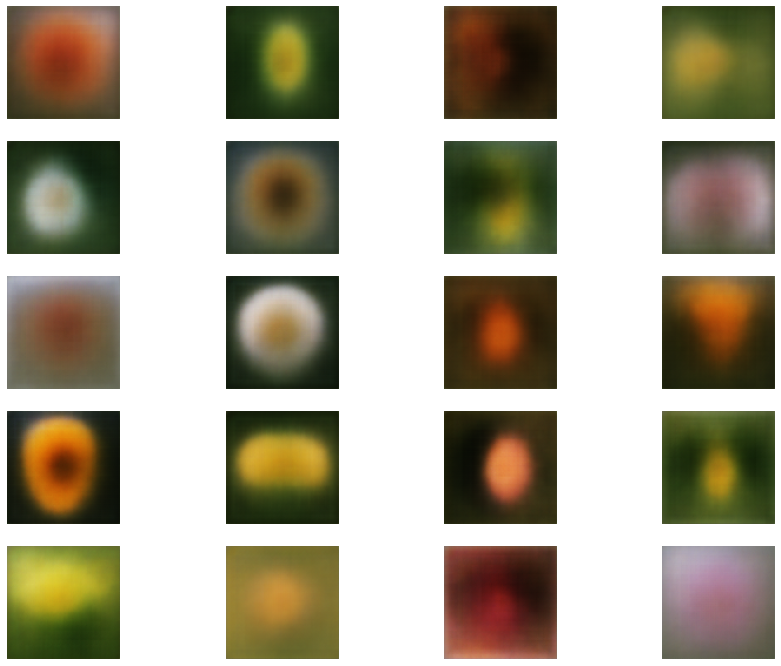

In [20]:
# visualize a few simulated flowers based on random sampling of means
random_codings = tf.random.normal(shape = [20, ENCODING_SIZE])
images = variational_decoder(random_codings).numpy()

plt.figure(figsize=(15, 12))

for i, image in enumerate(images):
  ax = plt.subplot(5, 4, i + 1)
  plt.imshow(image)
  plt.axis("off")

## Average Flower Generation 

Rather than generating images from random encoding values, the following parses the entire image dataset and for each flower type and computes the average encoding values.  Each average flower type representation is then decoded to generate the averge expected image for that flower type.  The figure shows 3 random examples for each flower type and the third image is processed through the variational autoencoder to evaluate the reconstruction. The last column shows an image generted from the average of encodings for each given flower type, providing insight into how the network internally represents each flower type in general.  

In [12]:
# set up a dictionary to store a few images of each flower 
# and a list of means to get the effective "average flower" 
# for each flower type
flower_means = {name:{'count':0, 'means':[0 for _ in range(ENCODING_SIZE)]} for name in flower_names}

# hold onto a set of examples from each flower type
flower_examples = {}

# for each flower image, run it through the encoder and extract the encodings 
# get the mean of the encodings for each flower type
# using the generator created earlier
for images, labels in flower_generator:
  means, gammas, coding = variational_encoder.predict(images / 255)
  for idx, mean in enumerate(means):
    flower_name = flower_names[labels[idx]]
    flower_means[flower_name]['count'] += 1

    for jdx, element in enumerate(mean):
      flower_means[flower_name]['means'][jdx] += element

    if flower_name not in flower_examples.keys():
      flower_examples[flower_name] = []
    if len(flower_examples[flower_name]) < 3:
      flower_examples[flower_name].append(images[idx] / 255)
    else:
      if random.random() < 0.5:
        flower_examples[flower_name][random.randint(0,2)] = images[idx] / 255

for k,v in flower_means.items():
  flower_means[k]['means'] = [m / flower_means[k]['count'] for m in flower_means[k]['means']]


In [13]:
# process mean vectors through decoder to generate
# an image of the "average" flower of each type
for i, (k, v) in enumerate(flower_means.items()):
  flower_means[k]['average_flower']= variational_decoder.predict([v['means']])[0] 

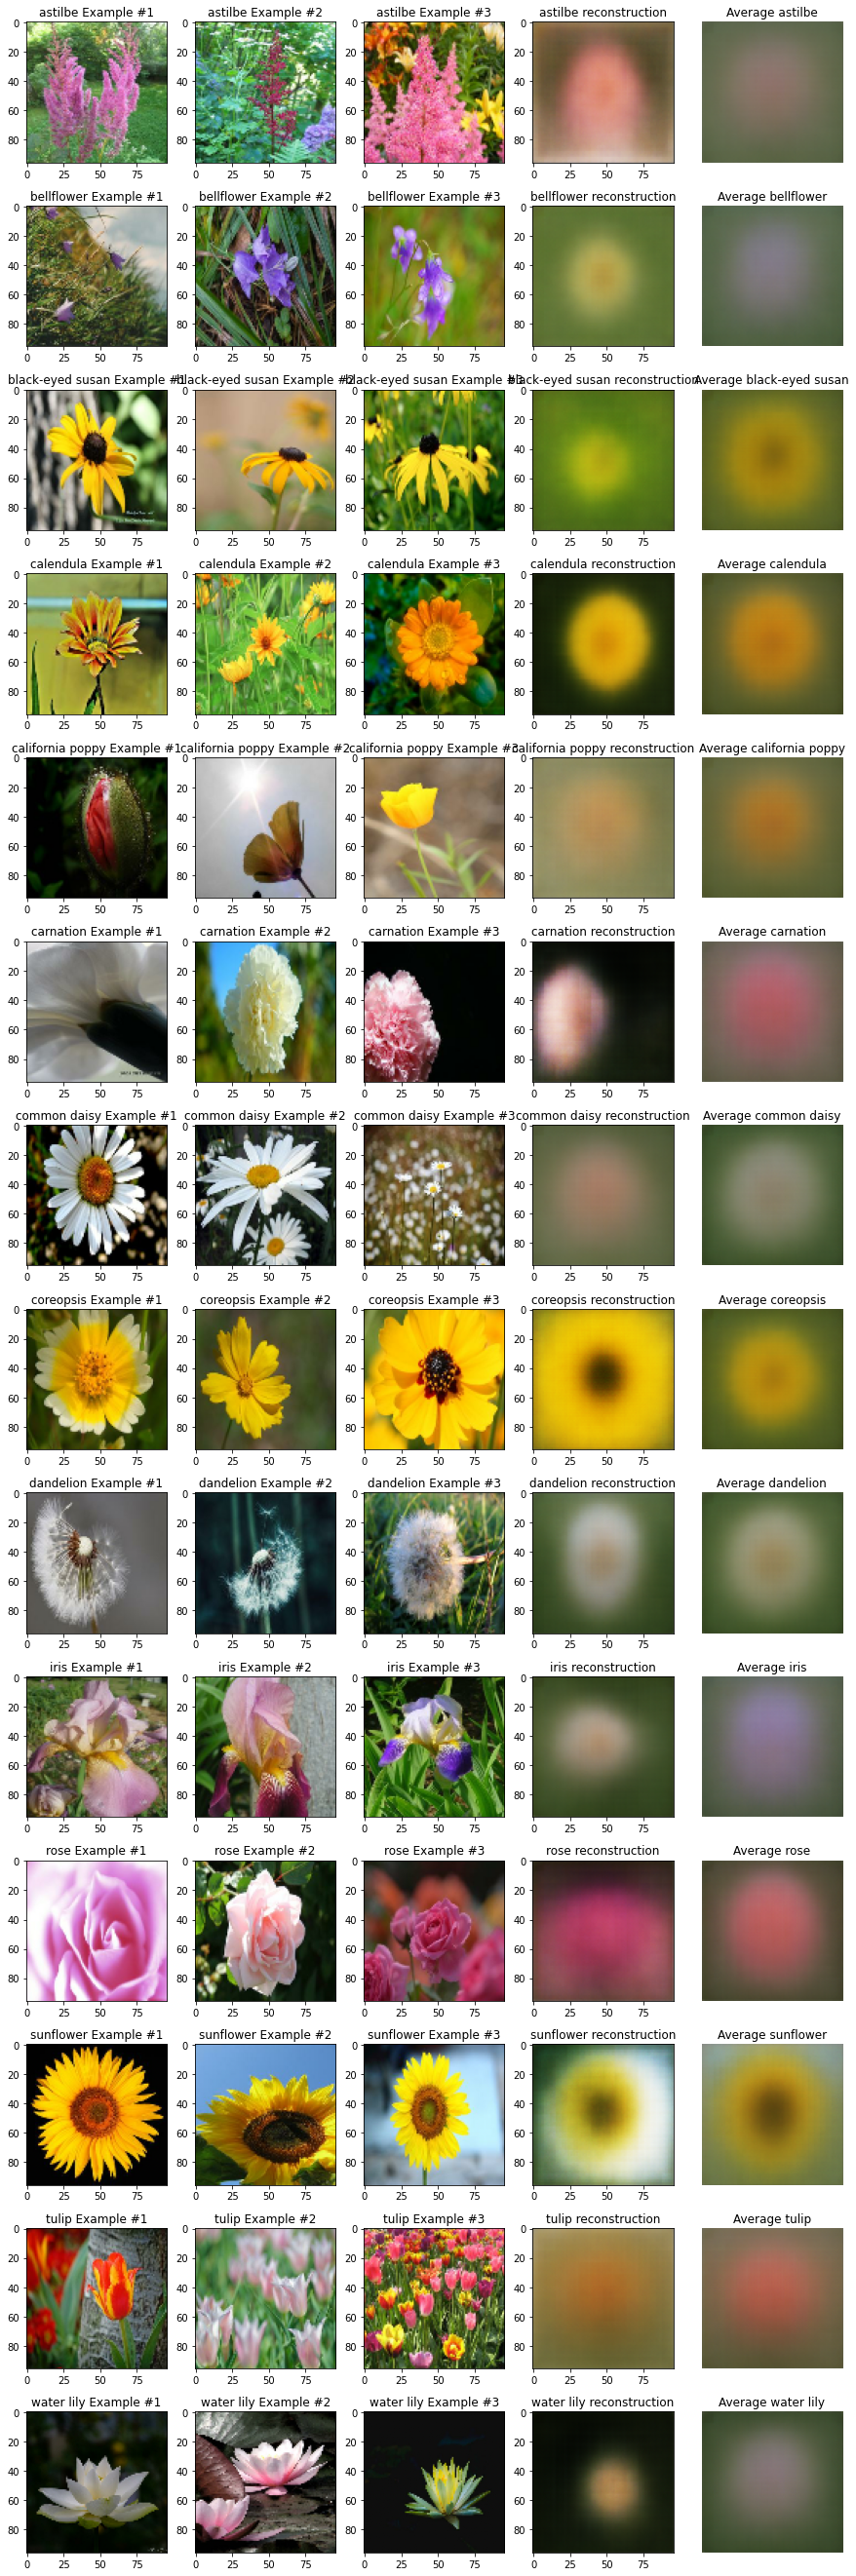

In [14]:
# compare examples, an example run through VAE
# and average flower
plt.figure(figsize=(15, 48))

for i, (k, v) in enumerate(flower_means.items()):
  original_example = flower_examples[k][2] # just process the third one
  processed_example = vae.predict(original_example[None, ...])
  average_flower = flower_means[k]['average_flower']

  ax = plt.subplot(14, 5, i * 5 + 1)
  plt.imshow(flower_examples[k][0])
  plt.title(k + ' Example #1')
  ax = plt.subplot(14, 5, i * 5 + 2)
  plt.imshow(flower_examples[k][1])
  plt.title(k + ' Example #2')
  ax = plt.subplot(14, 5, i * 5 + 3)
  plt.imshow(flower_examples[k][2])
  plt.title(k + ' Example #3')
  ax = plt.subplot(14, 5, i * 5 + 4)
  plt.imshow(processed_example[0])
  plt.title(k + ' reconstruction')
  ax = plt.subplot(14, 5, i * 5 + 5)
  plt.imshow(average_flower)
  plt.title('Average ' + k)
  plt.axis("off")

Comparing the original images with the generated average flower images reveals some interesting details.

* In each case, the generated average flower is nicely centered, albeit very fuzzy.  This is probably a reflection of most of the original flower images being well centered, but with different camera angles, flowers of varying colors, and a number of images consisting of fields of flowers rather than a single flower.
* Astilbe is composed of many small flowers on one stalk, and the images are often of a stalk with many of these flowers present.  The generated average is more square and generally pink to purple.
* Bellflower and iris generate a generally purple, square image, reflecting their flower structures and averaging of views from many different angles.  This variation in camera angles across different images leads to a more square average.
* Black-eyed susan, calendula, california poppy, and sunflower are very interesting to compare.  Each of these has a round flower, so different angles will still produce a round, average output.  Each one has a slightly different yellow color for petals, and a different color anddarkness of the center.  All of these features can be seen in the average images.  **See special note about sunflowers below with tulips.**
* Carnations and roses can be seen in many different colors, and their more complex petal structures lead to generated images that are also visually rougher.
* The common daisy has a generated image that is very relfective of a daisy - round, with white petals and a yellow center.
* The generated image for the dandelion is round and uniformly white, suggestng that most images are of the seed stage of the dandelion.  Looking closely at the gnerated image, however, a bit of yellow tint is also present, especially around the edges.  Most likely the image has a yellow component that isn't obvious throughout.
* The flower of a water lily can vary in color from white to yellow to purple.  The generated image is primarily white with some purple color at the edges, capturing a mixture of colors across images.  Interestingly, the background of the generated image is much darker than other flowers, reflective of the typical background of water lily being dark greek lily pads or dark water.
* Tulips deserve some special attention.  While the flower might be expected to produce a round average image like the other flowers, the tulip image is more square with a pink to red rectangle on top of a green rectangle, each of which extends the full width of the image.  Many images of tulips have multiple flowers in the picture or even fields of tulips, rather than a single flower.  The generated average image is thus reflective of choices made in composing the image moreso than the nature of the flowers themselves.  The generated sunflower image also shows this influence of image composition.  Looking at the background, the upper portion is greyish while the lower portion is light green.  Many sunflower pictures are taken with the sky in the upper portion of the background and the sunflower stalks in the lower portion, again, showing an influence of choices made by the photographer.

## Conclusion

While the generated images would not fool anyone into believeing they are real flowers, the average representations are reflective of the original images and characteristics of the flowers.  Of particular interest are the tulips and sunflowers which have clear artifacts of choices during image composition.  A classifier trained on a dataset like this may be well able to predict these two flowers, but perhaps based upon the nature of the flowers themselves, but rather some background artifacts.

The generated images represent regions between specific flower type averages and are effectively a morphing between types.  Additionally, while most images are well centered and aligned, there are many different camera angles and flowers are not consistently positioned.  This may explain why the images contains seemingly random color swatches that could be viewed as flower-like, albeit not convincing generations.

